In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.python.keras import regularizers
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from IPython.display import SVG
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import time
from keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import TensorBoard
import time
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import seaborn as sns
from sklearn.metrics import confusion_matrix
import collections
from sklearn.utils import shuffle
from keras.layers import LeakyReLU
from keras.layers.merge import concatenate
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train_images = pickle.load(open('/content/drive/My Drive/Datasets/DR_train_images.pkl','rb'))
train_labels = pickle.load(open('/content/drive/My Drive/Datasets/DR_train_labels.pkl','rb'))

In [ ]:
IMG_SIZE = 224
CHANNELS = 3

In [ ]:
data,Label = shuffle(train_images,train_labels, random_state=2)
training_data = [data,Label]
type(training_data)
(X, y) = (training_data[0],training_data[1])

In [ ]:
del data
del Label
del training_data
del train_images
del train_labels

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape

(9570, 224, 224, 3)

In [ ]:
Counter(y)

Counter({0: 1914, 1: 1914, 2: 1914, 3: 1914, 4: 1914})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=None,stratify=y)
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape  : ",X_test.shape)
print("y_test shape  : ",y_test.shape)

X_train shape :  (8613, 224, 224, 3)
y_train shape :  (8613,)
X_test shape  :  (957, 224, 224, 3)
y_test shape  :  (957,)


In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state=None,stratify=y_test)
print("X_val shape : ",X_val.shape)
print("y_val shape : ",y_val.shape)
print("X_test shape  : ",X_test.shape)
print("y_test shape  : ",y_test.shape)

X_val shape :  (478, 224, 224, 3)
y_val shape :  (478,)
X_test shape  :  (479, 224, 224, 3)
y_test shape  :  (479,)


In [ ]:
del X
del y

In [ ]:
Counter(y_train)

Counter({0: 1723, 1: 1723, 2: 1723, 3: 1722, 4: 1722})

In [ ]:
X_train.shape

(8613, 224, 224, 3)

In [ ]:
X_train.dtype

dtype('uint8')

In [ ]:
y_train.shape

(8613,)

In [ ]:
X_train.shape[1:]

(224, 224, 3)

In [ ]:
print(y_train[0:10])
#import collections
#collections.Counter(y_train)

[2 0 0 3 4 1 2 1 0 0]


<function matplotlib.pyplot.show>

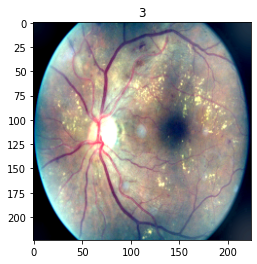

In [ ]:
plt.imshow(X_train[10])
plt.title(y_train[10])
plt.show

In [ ]:
print(np.unique(y_train))

[0 1 2 3 4]


In [ ]:
X_train.shape[1:]

(224, 224, 3)

In [ ]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [ ]:
# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(rescale=1.0/255.0)
# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, y_train, batch_size=8)
test_iterator = datagen.flow(X_test, y_test, batch_size=8)

In [ ]:
model = Sequential()
# first set of CONV => RELU => MAX POOL layers
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(5, activation='softmax'))

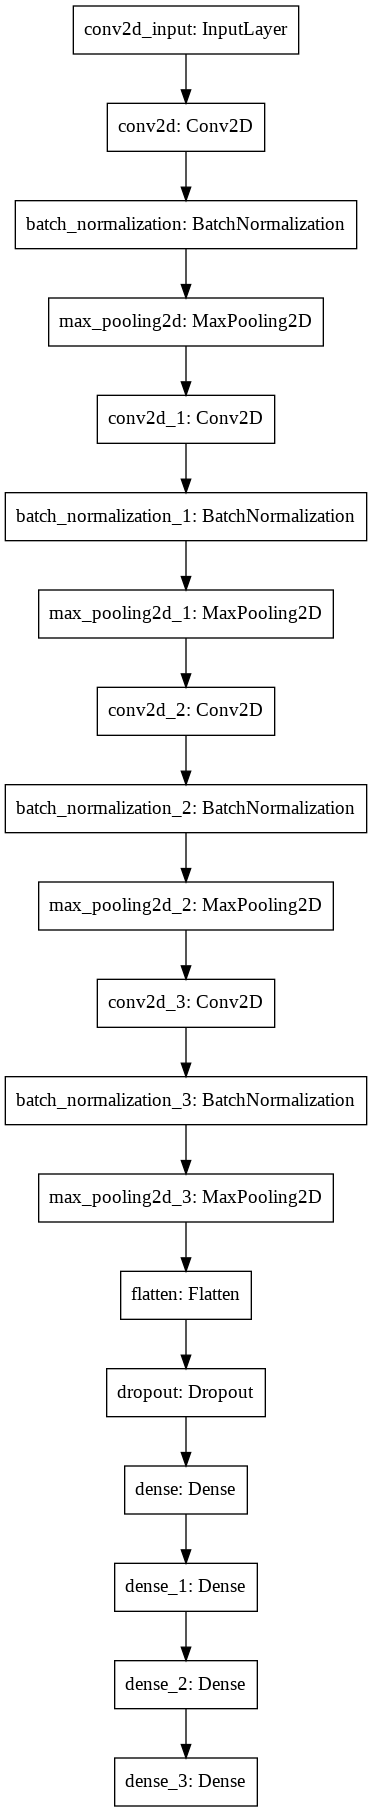

In [ ]:
plot_model(model, to_file='/content/drive/My Drive/Datasets/model_plot.png')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    min_delta=0.01, 
    mode='min',
    restore_best_weights=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(patience=2)

In [ ]:
#COMPILE
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [ ]:
history= model.fit(train_iterator,epochs=100,callbacks=[early_stopping,reduce_lr],batch_size=8,validation_data=test_iterator)

Epoch 1/100
1077/1077 [==============================] - 21s 16ms/step - loss: 3.0449 - accuracy: 0.2383 - val_loss: 1.8855 - val_accuracy: 0.2004
Epoch 2/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.7278 - accuracy: 0.2592 - val_loss: 1.6900 - val_accuracy: 0.2589
Epoch 3/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.6546 - accuracy: 0.2557 - val_loss: 1.6631 - val_accuracy: 0.2150
Epoch 4/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.6134 - accuracy: 0.2563 - val_loss: 1.6110 - val_accuracy: 0.2526
Epoch 5/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.6172 - accuracy: 0.2701 - val_loss: 1.6767 - val_accuracy: 0.2025
Epoch 6/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.6288 - accuracy: 0.2585 - val_loss: 1.8099 - val_accuracy: 0.2004
Epoch 7/100
1077/1077 [==============================] - 17s 16ms/step - loss: 1.5952 - accuracy: 0.2891 - val_loss: 1

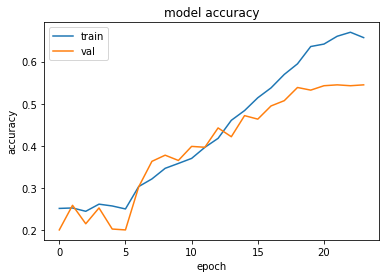

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

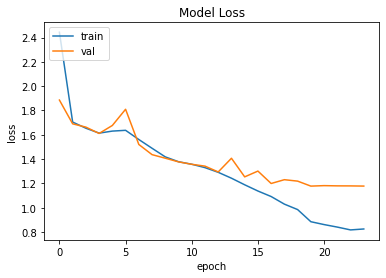

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_test.shape

(479, 224, 224, 3)

In [ ]:
X_test = X_test/255

In [ ]:
collections.Counter(y_test)

Counter({0: 96, 1: 96, 2: 95, 3: 96, 4: 96})

In [ ]:
collections.Counter(y_test)

Counter({0: 96, 1: 96, 2: 95, 3: 96, 4: 96})

In [ ]:
preds = model.evaluate(X_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]*100))

15/15 [==============================] - 1s 27ms/step - loss: 1.2188 - accuracy: 0.5386
Loss = 1.2187987565994263
Test Accuracy = 53.86221408843994


In [ ]:
y_predict = model.predict(X_test)

In [ ]:
y_predict=np.argmax(y_predict, axis=1)

In [ ]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.41      0.65      0.50        96
           1       0.37      0.16      0.22        96
           2       0.50      0.57      0.53        95
           3       0.71      0.60      0.65        96
           4       0.70      0.72      0.71        96

    accuracy                           0.54       479
   macro avg       0.54      0.54      0.52       479
weighted avg       0.54      0.54      0.52       479



In [ ]:
print(str(accuracy_score(y_test,y_predict)*100)+"%")
test_table = pd.crosstab(y_test,y_predict)
test_table

53.86221294363257%


col_0,0,1,2,3,4
row_0,,,,,
0,62,12,13,3,6
1,49,15,23,5,4
2,23,10,54,3,5
3,10,3,10,58,15
4,6,1,7,13,69


In [ ]:
collections.Counter(y_test)

Counter({0: 96, 1: 96, 2: 95, 3: 96, 4: 96})

In [ ]:
collections.Counter(y_predict)

Counter({0: 150, 1: 41, 2: 107, 3: 82, 4: 99})

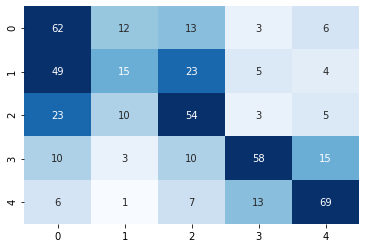

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_test.shape[0]//16)

In [ ]:
#perfomance of level 0
correct_prediction0 = test_table[0][0]
total_images0 = test_table[0].sum()
correct_percentage0 = correct_prediction0/total_images0*100
print("Level 0 correct prediction is: " +str(correct_percentage0)+ "%")

#perfomance of level 1
correct_prediction1 = test_table[1][1]
total_images1 = test_table[1].sum()
correct_percentage1 = correct_prediction1/total_images1*100
print("Level 1 correct prediction is: " +str(correct_percentage1)+ "%")

#perfomance of level 2
correct_prediction2 = test_table[2][2]
total_images2 = test_table[2].sum()
correct_percentage2 = correct_prediction2/total_images2*100
print("Level 2 correct prediction is: " +str(correct_percentage2)+ "%")

#perfomance of level 3
correct_prediction3 = test_table[3][3]
total_images3 = test_table[3].sum()
correct_percentage3 = correct_prediction3/total_images3*100
print("Level 3 correct prediction is: " +str(correct_percentage3)+ "%")

#perfomance of level 4
correct_prediction4 = test_table[4][4]
total_images4 = test_table[4].sum()
correct_percentage4 = correct_prediction4/total_images4*100
print("Level 4 correct prediction is: " +str(correct_percentage4)+ "%")

Level 0 correct prediction is: row_0
0    64.583333
1    64.583333
2    65.263158
3    64.583333
4    64.583333
dtype: float64%
Level 1 correct prediction is: 36.58536585365854%
Level 2 correct prediction is: 50.467289719626166%
Level 3 correct prediction is: 70.73170731707317%
Level 4 correct prediction is: 69.6969696969697%


In [ ]:
model.save('/content/drive/My Drive/Datasets/DR Model/dr_model.h5')
#pickle.dump(model, open('/content/drive/My Drive/Datasets/tfmodel.model','wb'))

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/Datasets/DR Model/dr_model.h5')

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
IMG_SIZE = 224
def read_img(img): 
    img_original = cv2.imread(img,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_CUBIC)
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 30) ,-4 ,128)
    return image

In [ ]:
#prediction
test_image = "17_right.jpeg"
img_path = os.path.join( "/content/drive/My Drive/sample/", test_image)
img_arr = read_img(img_path)
img_arr = np.expand_dims(img_arr, axis=0)

prediction = model.predict(img_arr)
print(prediction[0])
MaxPosition=np.array(prediction[0]).argmax()
classes = ['No DR','Mild NPDR', 'Moderate NPDR','Severe NPDR', 'PDR']
prediction_label=classes[MaxPosition]
pred = max(prediction[0])
print(str(pred*100) +"% "+ prediction_label)

[0.000000e+00 9.159297e-26 1.000000e+00 0.000000e+00 0.000000e+00]
100.0% Moderate NPDR


In [ ]:
# Convert the model to standard TensorFlow Lite model
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tfmodel = converter.convert()
#open ("/content/drive/My Drive/Datasets/DR Model/dr_tflite_model.tflite" , "wb") .write(tfmodel)

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

In [ ]:
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open("/content/drive/My Drive/Datasets/DR Model/dr_tflite_model.tflite", "wb").write(converted_tflite_model)

26259856

In [ ]:
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open("/content/drive/My Drive/Datasets/DR Model/dr_tflite_quant_model.tflite", "wb").write(tflite_quant_model)

6581424

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path="/content/drive/My Drive/Datasets/DR Model/dr_tflite_model.tflite")

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
shape: [1 5]
type: <class 'numpy.float32'>
